In [ ]:
import matplotlib.pyplot as plt                   
import numpy as np                                
import os #Operaciones Sistema Operativo
import PIL #Edición de imágenes directamente desde Python. 
import tensorflow as tf
import glob #retorna Rutas de archivo que coinciden con un patrón específico

from tensorflow import keras
from tensorflow.keras import layers #Capas para el modelo
from tensorflow.keras.models import Sequential #Instancias del modelo secuencial

In [ ]:
from google.colab import files #Cargar archivos a colab
uploaded = files.upload() #Se cargan los datos en un archivo

Saving Base.zip to Base (1).zip


In [ ]:
import zipfile #Procesamiento de archivos zip
import io #Tipos de E/S.(texto/binario/sin formato)
data = zipfile.ZipFile(io.BytesIO(uploaded['Base.zip']), 'r')  
data.extractall()

In [ ]:
import pathlib #Rutas de sistemas de archivos para diferentes sistemas operativos. 
data_dir = tf.keras.utils.get_file('/content/Base','/content/Base',) #Se pasan a data dir
data_dir = pathlib.Path(data_dir) #se crea un pat con los archivos de data dir
print(data_dir)

/content/Base


In [ ]:

image_count = len(list(data_dir.glob('*/*'))) #se cuentan y muestran la cantidad de archivos
print(image_count)

44


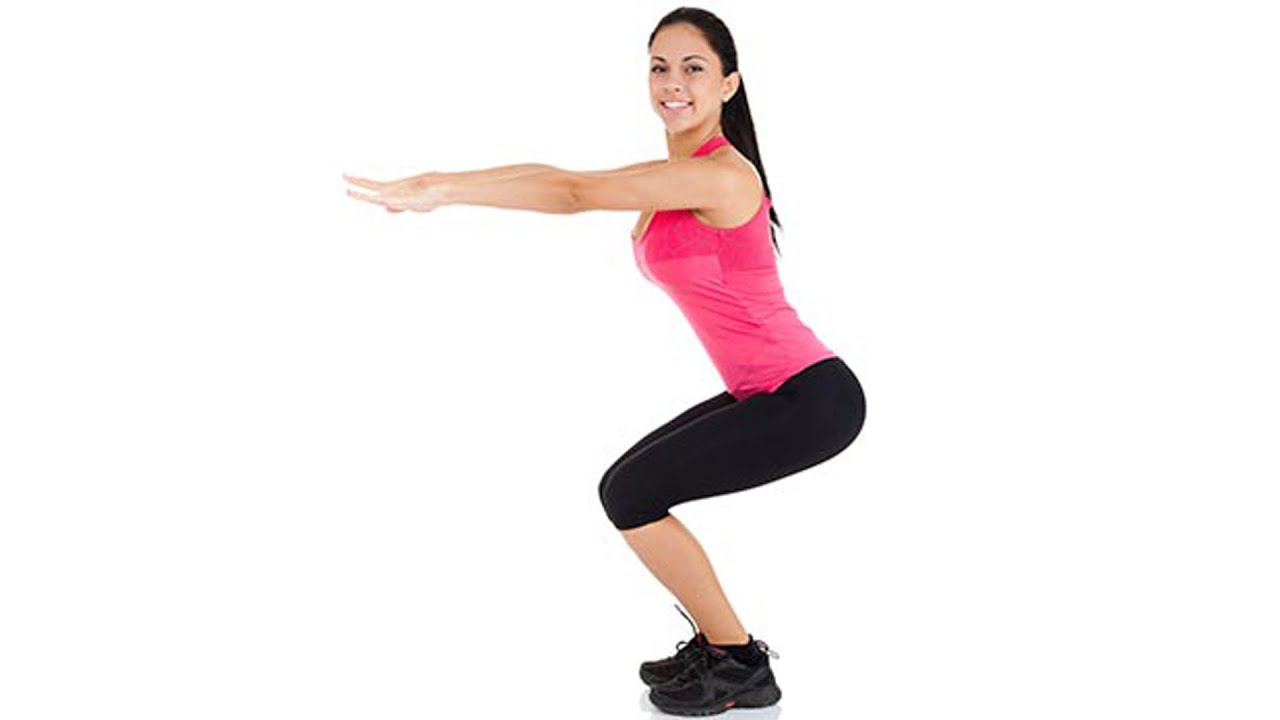

In [ ]:
ermita = list(data_dir.glob('sentadillas/*')) #se verifica la carga de archivos
PIL.Image.open(str(ermita[0]))

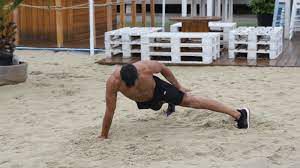

In [ ]:
Gato = list(data_dir.glob('lagartijas/*')) #se verifica la carga de archivos
PIL.Image.open(str(Gato[0]))

In [ ]:
batch_size = 32    # Se tomarán 32 muestras para cada entrenamiento
img_height = 180 # se estandariza el tamaño de la imagen de 180 x 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: ignored

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 44 files belonging to 3 classes.
Using 8 files for validation.


In [ ]:
val_ds


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['elevacion de brazos', 'lagartijas', 'sentadillas']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

NameError: ignored

<Figure size 720x720 with 0 Axes>

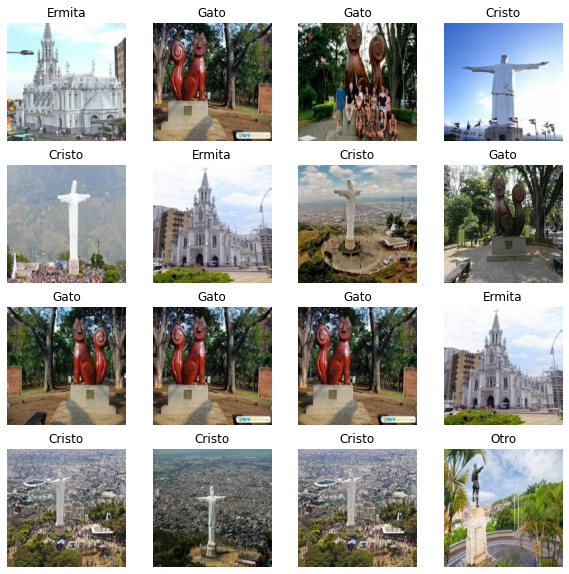

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#image_batch es un tensor de (32,180,180,3), 
#lotes de 32 imágenes de 180x180x3 (canal RGB)
#labels_batch es un tensor de (32), esto correspondiente a las 32 imágenes.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
#Configuración del conjunto para el rendimiento
#Datasat_cache() las imagenes se mantienen en el cache en la primera epoch. 
#Dataset_Prefetch superpone el procesamiento y la ejecución del modelo durante el entrenamiento.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Estandarización o Escalamiento de los datos
#Los valores RGB generan un rango de 0 a 255 (0,255). 
#La red necessida valores más pequeños (0,1), se hace un cambio de escala.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = 4
#Se configura modelo con 3 capas convolucionales 2D de 16, 32, 64 nodos
#tres (3) dimensiones, same y relu
#Una capa de densidad de 128 unidades y otra con la cantidad de clases
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'), 
  layers.Dense(num_classes)
])

In [ ]:
#Se compilta el modelo con el optimizador ADAM 
#Función de perdida Entropia Cruzada (tenemos más de dos clases)
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),                                         
metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
#Entrenamiento con 20 epocas (más pequeña la muestra más cantidad de epocas)
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 9s 1s/step - loss: 1.8832 - accuracy: 0.4048 - val_loss: 1.1551 - val_accuracy: 0.3065
Epoch 2/20
8/8 [==============================] - 8s 1s/step - loss: 0.7107 - accuracy: 0.7341 - val_loss: 0.4091 - val_accuracy: 0.8065
Epoch 3/20
8/8 [==============================] - 8s 1s/step - loss: 0.2442 - accuracy: 0.9524 - val_loss: 0.1235 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 8s 1s/step - loss: 0.0515 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 8s 1s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - 8s 1s/step - loss: 8.9364e-04 - accuracy: 1.0000 - val_loss: 4.1605e-04 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 8s 1s/step - loss: 3.0233e-04 - accuracy: 1.0000 - val_loss: 1.5692e-04 - val_accuracy: 1.0000
Epoch 8/20
8/8 [=========

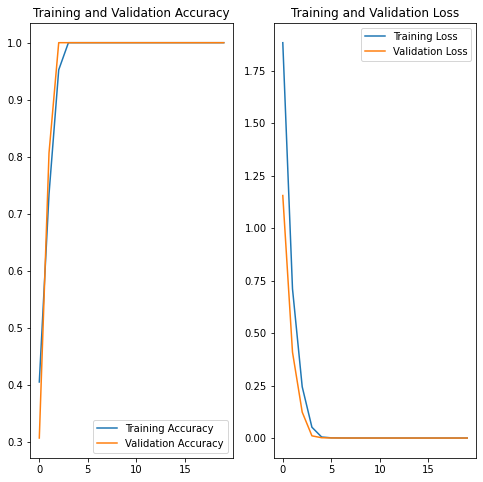

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

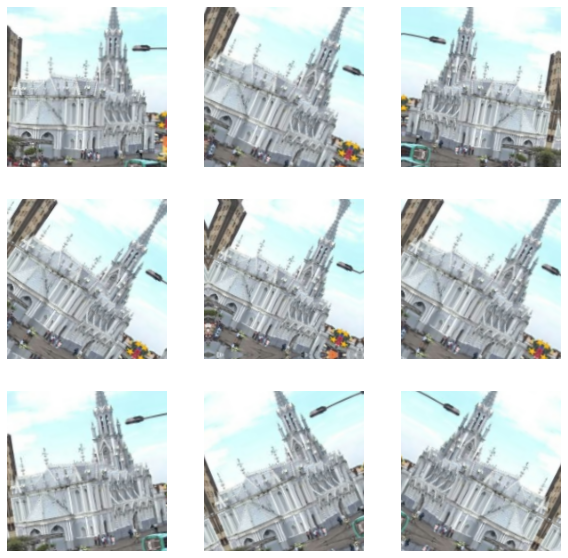

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  

  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min')

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 1.2319 - accuracy: 0.4127 - val_loss: 1.0570 - val_accuracy: 0.5323
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 0.8823 - accuracy: 0.6746 - val_loss: 0.7683 - val_accuracy: 0.6452
Epoch 3/20
8/8 [==============================] - 19s 2s/step - loss: 0.6600 - accuracy: 0.7460 - val_loss: 0.6855 - val_accuracy: 0.6774
Epoch 4/20
8/8 [==============================] - 19s 2s/step - loss: 0.5527 - accuracy: 0.7738 - val_loss: 0.4414 - val_accuracy: 0.7903
Epoch 5/20
8/8 [==============================] - 18s 2s/step - loss: 0.4099 - accuracy: 0.8413 - val_loss: 0.3340 - val_accuracy: 0.9194
Epoch 6/20
8/8 [==============================] - 18s 2s/step - loss: 0.3646 - accuracy: 0.8611 - val_loss: 0.4048 - val_accuracy: 0.8710
Epoch 7/20
8/8 [==============================] - 20s 3s/step - loss: 0.3803 - accuracy: 0.8294 - val_loss: 0.2696 - val_accuracy: 0.9516
Epoch 8/20
8/8 [==================

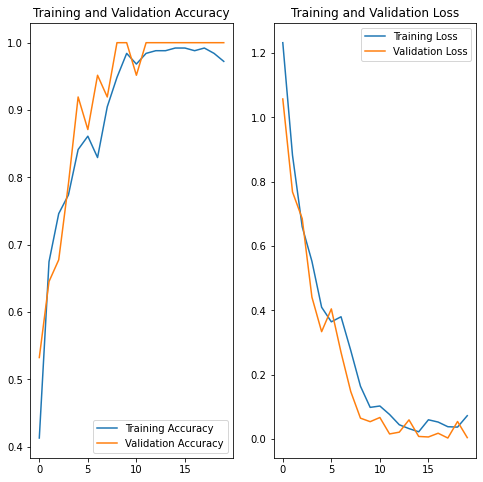

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Prba.zip to Prba.zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['Prba.zip']), 'r')
data.extractall()

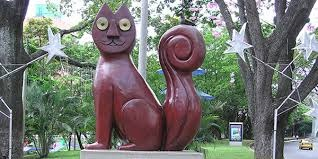

In [ ]:
from IPython.display import Image
Image(filename='/content/Prba/Gato_p2.jpg')

In [ ]:
sitioDiag= {'Ermita' : 'Iglesia la Ermita' ,'Cristo' : 'Cerro de Cristo Rey','Gato' : 'El parque del Gato','Otro': 'Mirador San Sebastian'}

In [ ]:
sunflower_url = "/content/Prba/Gato_p2.jpg"
sunflower_path = tf.keras.utils.get_file('///content/Prba/Gato_p2.jpg', '/content/Prba/')

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
     "{} {:.2f}% es la probabilidad del acierto del sitio turístico.\n"
    .format(sitioDiag [class_names[np.argmax(score)]], 100 * np.max(score))
    
    
)

El parque del Gato 99.69% es la probabilidad del acierto del sitio turístico.

